In [122]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import time
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = (10,8)

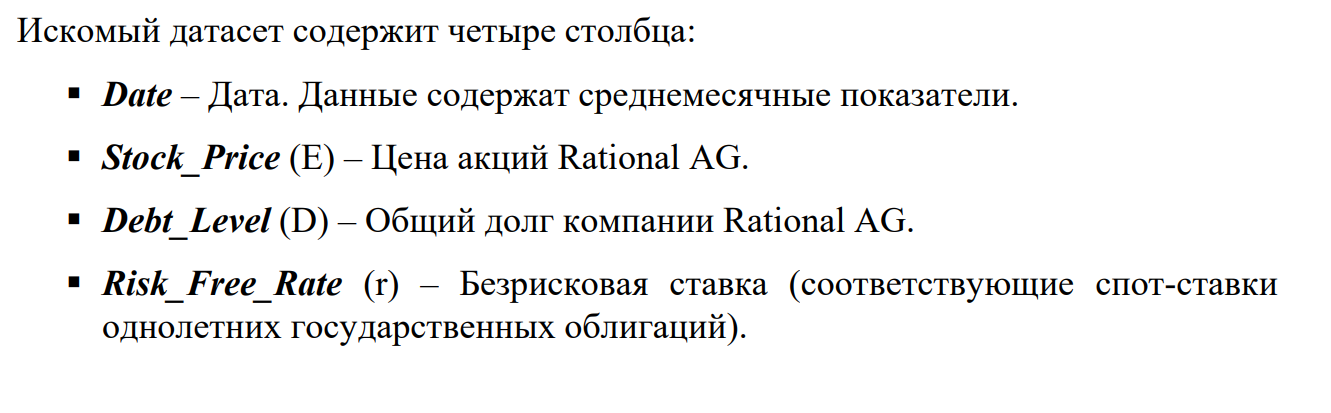

In [123]:
dtype = float

In [124]:
data = pd.read_csv('financial_data.csv', sep=';', parse_dates=['Date'])
data

,Date,Stock_Price,Debt_Level,Risk_Free_Rate
0,2019-01-31,"63,39750065","71,57160705","0,05"
1,2019-02-28,"66,66943855","88,9897677",NaN
2,2019-03-31,"76,34750548","61,65649484",NaN
3,2019-04-30,"80,40762596","52,61432516",NaN
4,2019-05-31,"79,97121707","91,98960417",NaN
5,2019-06-30,"78,48411159","96,34617357","0,1"
6,2019-07-31,"81,85833442","79,56013214",NaN
7,2019-08-31,"71,36728217","99,13415707",NaN
8,2019-09-30,"77,12128993","87,80040594",NaN
9,2019-10-31,"74,81016679","56,68941527",NaN


# Приводим данные к нужному формату

In [125]:
num_cols = ['Stock_Price', 'Debt_Level', 'Risk_Free_Rate']
for i in num_cols:
    data_i = []
    for j in data[i]:
        try:
            data_i.append(float(j.replace(',','.')))
        except:
            data_i.append(np.nan)
    data[i] = data_i
    data[i] = data[i].astype(dtype)
data

,Date,Stock_Price,Debt_Level,Risk_Free_Rate
0,2019-01-31,63.397501,71.571607,0.05
1,2019-02-28,66.669439,88.989768,NaN
2,2019-03-31,76.347505,61.656495,NaN
3,2019-04-30,80.407626,52.614325,NaN
4,2019-05-31,79.971217,91.989604,NaN
5,2019-06-30,78.484112,96.346174,0.10
6,2019-07-31,81.858334,79.560132,NaN
7,2019-08-31,71.367282,99.134157,NaN
8,2019-09-30,77.121290,87.800406,NaN
9,2019-10-31,74.810167,56.689415,NaN


# Напишем функцию для Интерполяционного члена Лагранжа

In [126]:
def lagrange_interpolation(x_values, y_values):
    if len(x_values) != len(y_values):
        raise ValueError("x_values and y_values must have the same length")
    n = len(x_values)
    # Проверка уникальности x_values
    for i in range(n):
        for j in range(i + 1, n):
            if x_values[i] == x_values[j]:
                raise ValueError("x_values must be distinct")
    
    def _basis(i, x):
        term = 1.0
        xi = x_values[i]
        for j in range(n):
            if j != i:
                xj = x_values[j]
                term *= (x - xj) / (xi - xj)
        return term
    
    def _lagrange(x):
        total = 0.0
        for i in range(n):
            total += y_values[i] * _basis(i, x)
        return total
    
    return _lagrange

poly = lagrange_interpolation([1, 2, 3], [1, 4, 9])
print(poly(4))

16.0


In [127]:
def quadratic_interpolate(series, just_gaps=False):
    """
    Восстанавливает пропуски в одномерном массиве series,
    используя квадратичную интерполяцию на основе ближайших 3 валидных точек.
    """
    gaps = []
    series_filled = series.copy()
    n = len(series)

    
    # Для простоты используем индексы как x (при равномерной выборке)
    x = np.arange(n)
    
    for i in range(n):
        if pd.isna(series[i]):
            vars = []
            for left in [1,2]:  
                # Сначала ищем валидные точки с ближайших соседей.
                valid_idx = []
                # Сначала смотрим влево
                j = i - 1
                while j >= 0 and len(valid_idx) < left:
                    if not pd.isna(series[j]):
                        valid_idx.append(j)
                    j -= 1
                # Затем справа собираем до 2-х точек
                j = i + 1
                while j < n and len(valid_idx) < 3:
                    if not pd.isna(series[j]):
                        valid_idx.append(j)
                    j += 1
                # Если не нашли 3 точки, можно дополнительно искать влево
                j = i - 1
                while j >= 0 and len(valid_idx) < 3:
                    if not pd.isna(series[j]) and j not in valid_idx:
                        valid_idx.append(j)
                    j -= 1

                if len(valid_idx) < 3:
                    # Если всё ещё недостаточно точек – пропускаем восстановление.
                    continue

                # Сортируем индексы для упорядоченности
                valid_idx = sorted(valid_idx)
                x_points = x[valid_idx]
                y_points = series[valid_idx].values
                
                
                #print(x_points,y_points)
                # Находим значение с помощью многочлена лагранжа
                poly = lagrange_interpolation(x_points, y_points)(i)
                
                # Выберем точку, ближайшую к данным
                x_points = list(x_points)
                x_points.append(i)
                x_points = sorted(x_points)
                x_points.index(i)
                
                
                min_y_differ = min(abs(y_points[x_points.index(i)-1]-poly), abs(y_points[x_points.index(i)]-poly))
                vars.append((poly, min_y_differ))
            
            
            zip_var = list(zip(*vars))
            
            # И добавим ее в ответ
            series_filled[i] = zip_var[0][zip_var[1].index(min(zip_var[1]))]
            gaps.append([i,zip_var[0][zip_var[1].index(min(zip_var[1]))]])
            
    if just_gaps:
        return pd.Series(list(zip(*gaps))[1],index = list(zip(*gaps))[0],dtype=dtype)
    
    series_filled = series_filled.astype(dtype)
    
    return series_filled

# Первая подзадача:

## С помощью квадратичной интерполяции восстановим точки

In [128]:
data_copy = data.copy()

for i in ['Stock_Price', 'Risk_Free_Rate']:
    data_copy[i] = quadratic_interpolate(data_copy[i])

display(data_copy)

,Date,Stock_Price,Debt_Level,Risk_Free_Rate
0,2019-01-31,63.397501,71.571607,0.050000
1,2019-02-28,66.669439,88.989768,0.065455
2,2019-03-31,76.347505,61.656495,0.078182
3,2019-04-30,80.407626,52.614325,0.088182
4,2019-05-31,79.971217,91.989604,0.095455
5,2019-06-30,78.484112,96.346174,0.100000
6,2019-07-31,81.858334,79.560132,0.098571
7,2019-08-31,71.367282,99.134157,0.100909
8,2019-09-30,77.121290,87.800406,0.097273
9,2019-10-31,74.810167,56.689415,0.090909


In [129]:
data_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            36 non-null     datetime64[ns]
 1   Stock_Price     36 non-null     float64       
 2   Debt_Level      36 non-null     float64       
 3   Risk_Free_Rate  36 non-null     float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.3 KB


## Построим графики

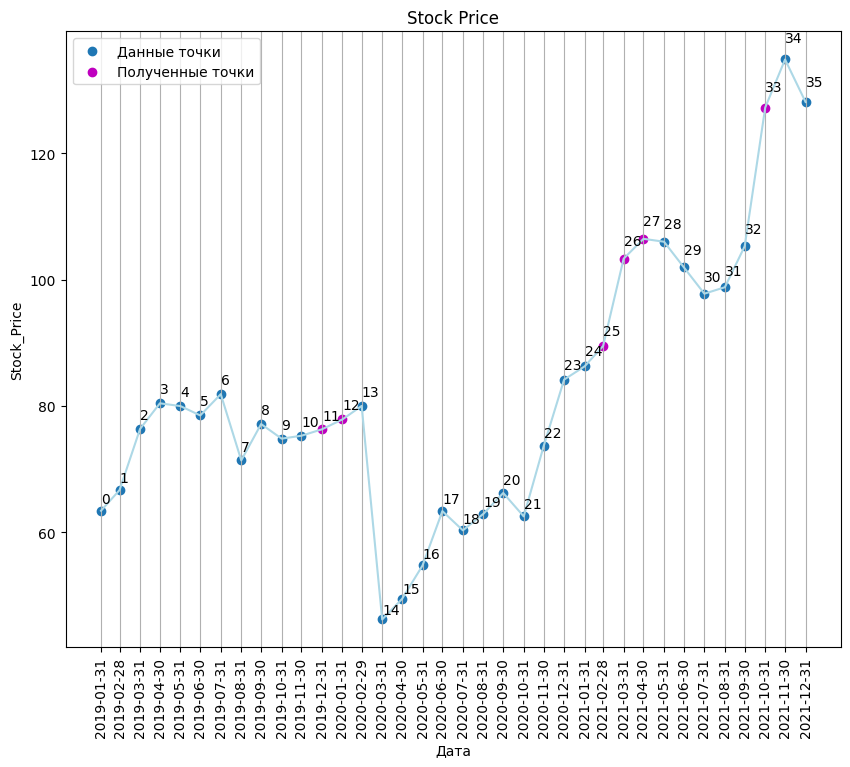

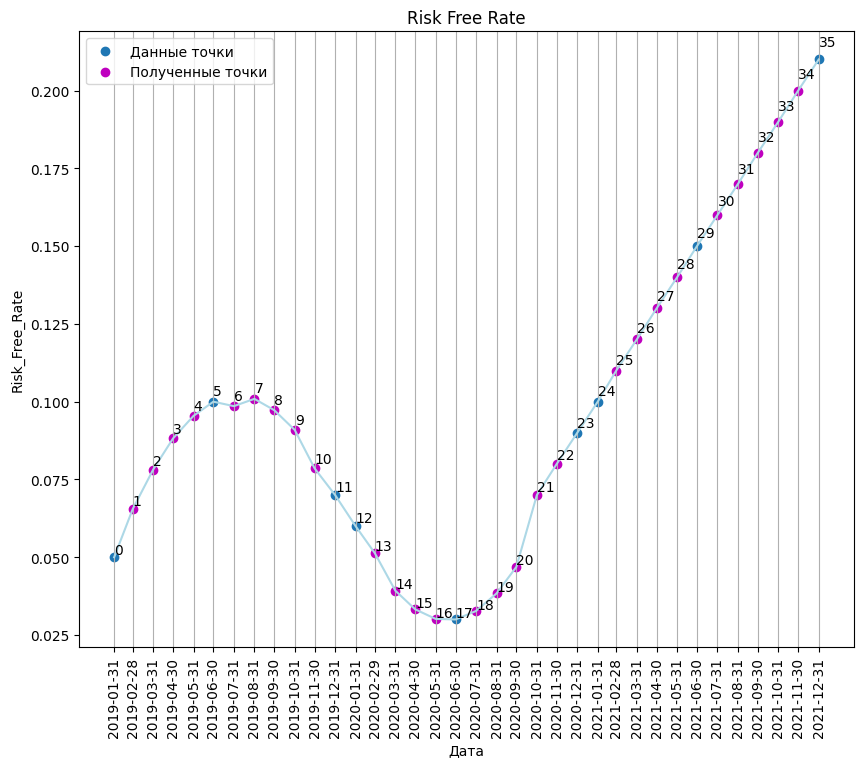

In [130]:
for i in ['Stock_Price', 'Risk_Free_Rate']:    
    plt.plot(data_copy.Date, data_copy[i] ,c='lightblue')
    
    plt.scatter(data[(data_copy[i] == data[i])].Date ,data[(data_copy[i] == data[i])][i].values, label = 'Данные точки')
    plt.scatter(data[(data_copy[i] != data[i])].Date, data_copy[(data_copy[i] != data[i])][i].values,c='m', label = 'Полученные точки')

    plt.xticks(data.Date)
    plt.xticks(rotation=90)

    data_copy.apply(lambda x: plt.annotate(x.name,(x.Date,x[i]*1.02)),axis=1)

    plt.title(i.replace('_',' '))
    plt.ylabel(i)
    plt.xlabel('Дата')
    plt.grid(axis='x')
    plt.legend()
    plt.show()

# Вторая подзадача:

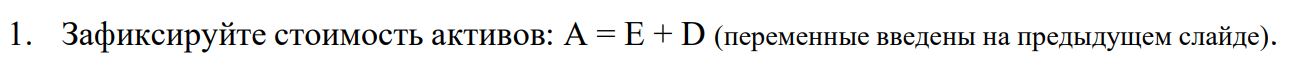

In [131]:
dc = data_copy.copy()
dc.columns = ['Date','E','D','r']
dc['A'] = dc.E + dc.D
dc

,Date,E,D,r,A
0,2019-01-31,63.397501,71.571607,0.050000,134.969108
1,2019-02-28,66.669439,88.989768,0.065455,155.659206
2,2019-03-31,76.347505,61.656495,0.078182,138.004000
3,2019-04-30,80.407626,52.614325,0.088182,133.021951
4,2019-05-31,79.971217,91.989604,0.095455,171.960821
5,2019-06-30,78.484112,96.346174,0.100000,174.830285
6,2019-07-31,81.858334,79.560132,0.098571,161.418467
7,2019-08-31,71.367282,99.134157,0.100909,170.501439
8,2019-09-30,77.121290,87.800406,0.097273,164.921696
9,2019-10-31,74.810167,56.689415,0.090909,131.499582


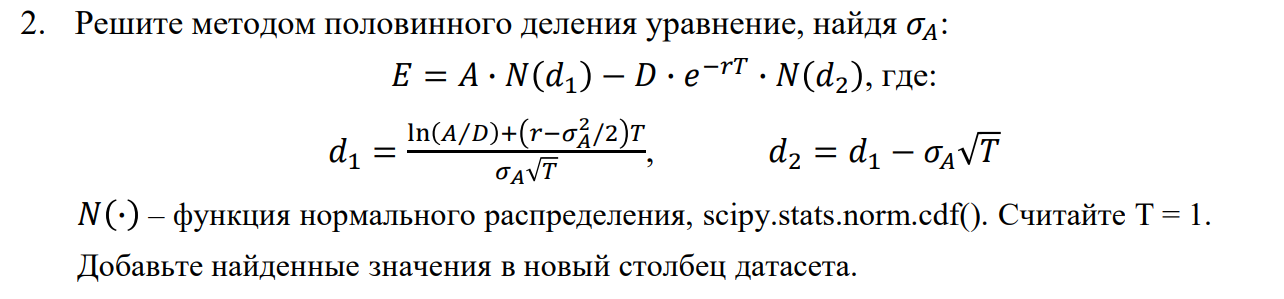

In [132]:
from scipy.stats import norm
N = norm.cdf

T = 1

def e_func(sigma,E,A,D,r):
    
    
    d1 = (np.log(A/D) + (r-0.5 * sigma**2)* T)/(sigma*T**0.5)
    d2 = d1 - (sigma*T**0.5)
    
    return dtype(E - (A*N(d1) - D* np.exp((-1)*r*T)*N(d2)))



def bisection(f, a, b, tol, params, max_iters=10000 ):
    if np.sign(f(a, *params)) == np.sign(f(b, *params)):
        raise Exception("a and b can't provide you with root")
    
    m = (a+b)/2
    
    iters = 0
    while np.abs(f(m, *params))>tol and  iters<max_iters:
        
        
        if f(m,*params) == 0:
            return m
        
        if np.sign(f(a, *params)) == np.sign(f(m, *params)):
            a = m
        elif np.sign(f(b, *params)) == np.sign(f(m, *params)):
            b = m
        
        m = (a+b)/2
        iters+=1
        

    return dtype(m) 

dc_sa = []
for _ in dc.loc[:,['E','A','D','r']].values:
    dc_sa.append(bisection(e_func, 1e-10,1e2,1e-12,_))

dc['sA'] = (dc_sa)
dc

,Date,E,D,r,A,sA
0,2019-01-31,63.397501,71.571607,0.050000,134.969108,0.992029
1,2019-02-28,66.669439,88.989768,0.065455,155.659206,1.124069
2,2019-03-31,76.347505,61.656495,0.078182,138.004000,0.913969
3,2019-04-30,80.407626,52.614325,0.088182,133.021951,0.884698
4,2019-05-31,79.971217,91.989604,0.095455,171.960821,1.095492
5,2019-06-30,78.484112,96.346174,0.100000,174.830285,1.137426
6,2019-07-31,81.858334,79.560132,0.098571,161.418467,1.023532
7,2019-08-31,71.367282,99.134157,0.100909,170.501439,1.208796
8,2019-09-30,77.121290,87.800406,0.097273,164.921696,1.093522
9,2019-10-31,74.810167,56.689415,0.090909,131.499582,0.923547


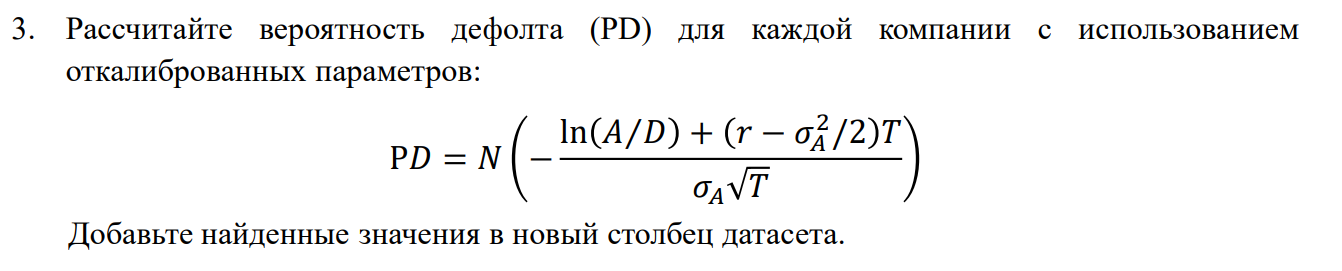

In [133]:
dc['PD'] = np.vectorize(dtype)(N(- (np.log(dc.A/dc.D) + (dc.r-0.5 * dc.sA**2)* T)/(dc.sA*T**0.5)))
dc

,Date,E,D,r,A,sA,PD
0,2019-01-31,63.397501,71.571607,0.050000,134.969108,0.992029,0.423154
1,2019-02-28,66.669439,88.989768,0.065455,155.659206,1.124069,0.502542
2,2019-03-31,76.347505,61.656495,0.078182,138.004000,0.913969,0.304991
3,2019-04-30,80.407626,52.614325,0.088182,133.021951,0.884698,0.240177
4,2019-05-31,79.971217,91.989604,0.095455,171.960821,1.095492,0.456027
5,2019-06-30,78.484112,96.346174,0.100000,174.830285,1.137426,0.482819
6,2019-07-31,81.858334,79.560132,0.098571,161.418467,1.023532,0.391366
7,2019-08-31,71.367282,99.134157,0.100909,170.501439,1.208796,0.528825
8,2019-09-30,77.121290,87.800406,0.097273,164.921696,1.093522,0.452763
9,2019-10-31,74.810167,56.689415,0.090909,131.499582,0.923547,0.291938


# Третья подзадача:

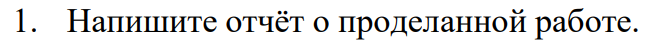

**Отчет о проделанной работе**

- **Предобработка данных**:  
  - Загружены данные из CSV-файла, обработаны числовые столбцы (замена запятых на точки, преобразование в тип `float`). 
  - Пропуски в столбцах *Stock_Price* (цена акций) и *Risk_Free_Rate* (безрисковая ставка) восстановлены с помощью **квадратичной интерполяции** на основе ближайших точек.  

- **Расчет финансовых метрик**:  
  - Вычислены **суммарные активы** компании: $ A = E + D $ (где $ E $ — стоимость акций, $ D $ — долг).  
  - Определена **волатильность активов** ($ \sigma_A $) с использованием метода бисекции для решения уравнения Блэка-Шоулза.  
  - Рассчитана **вероятность дефолта** (PD) через нормальное распределение.  

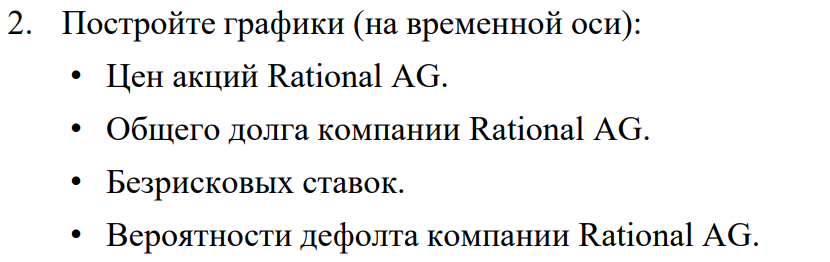

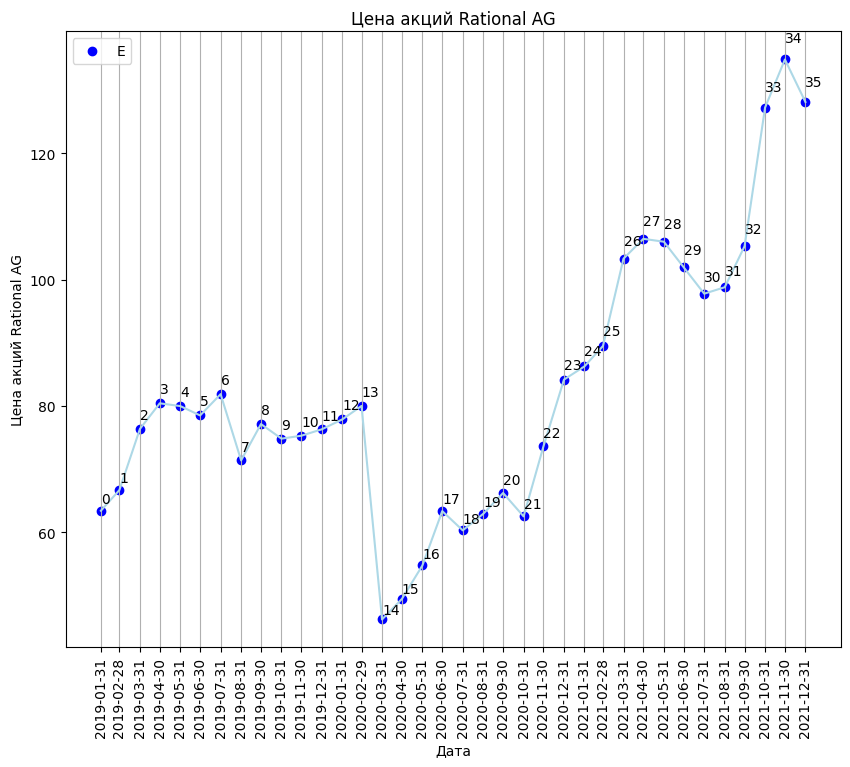

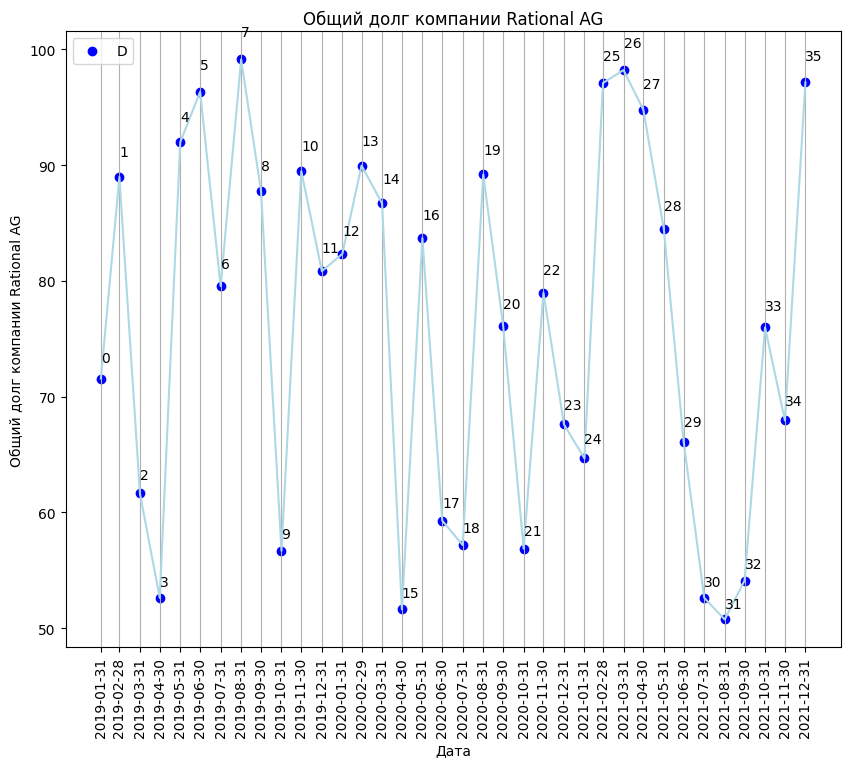

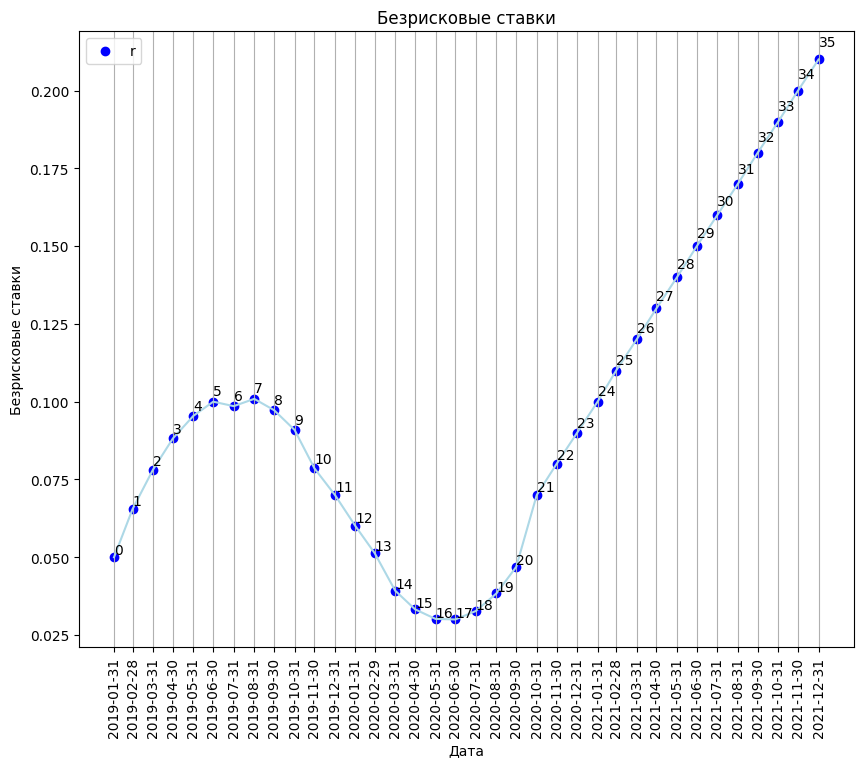

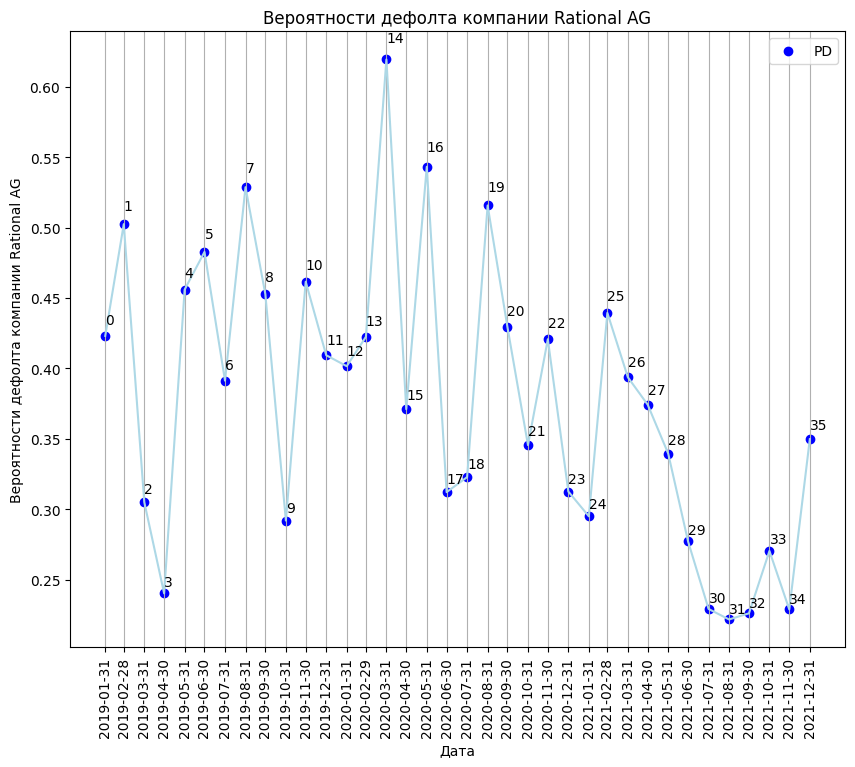

In [134]:
need_cols = ['E', 'D', 'r', 'PD']
labels = [
    'Цена акций Rational AG',
    'Общий долг компании Rational AG',
    'Безрисковые ставки',
    'Вероятности дефолта компании Rational AG'
]
for i in range(len(need_cols)):  
    plt.plot(dc.Date, dc[need_cols[i]] ,c='lightblue')
    plt.scatter(dc.Date, dc[need_cols[i]] ,c='b', label = need_cols[i])

    plt.xticks(data.Date)
    plt.xticks(rotation=90)

    dc.apply(lambda x: plt.annotate(x.name,(x.Date,x[need_cols[i]]*1.02)),axis=1)

    plt.title(labels[i].replace('_',' '))
    plt.ylabel(labels[i])
    plt.xlabel('Дата')
    plt.grid(axis='x')
    plt.legend()
    plt.show()

In [135]:
dc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36 entries, 0 to 35
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    36 non-null     datetime64[ns]
 1   E       36 non-null     float64       
 2   D       36 non-null     float64       
 3   r       36 non-null     float64       
 4   A       36 non-null     float64       
 5   sA      36 non-null     float64       
 6   PD      36 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 2.1 KB


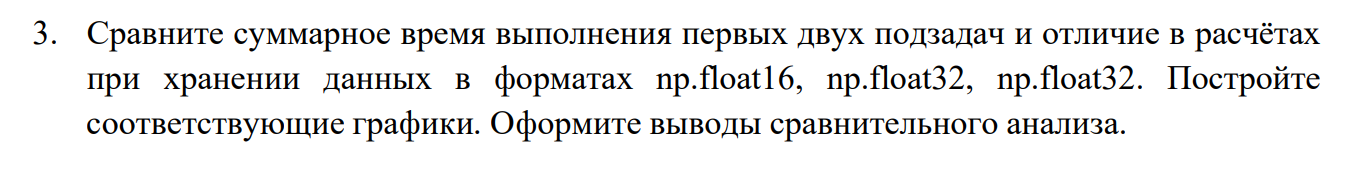

Возьмем точности вычисления как `tols = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]`

In [136]:
from scipy.stats import norm
N = norm.cdf

def lagrange_interpolation(x_values, y_values):
    if len(x_values) != len(y_values):
        raise ValueError("x_values and y_values must have the same length")
    n = len(x_values)
    # Проверка уникальности x_values
    for i in range(n):
        for j in range(i + 1, n):
            if x_values[i] == x_values[j]:
                raise ValueError("x_values must be distinct")
    
    def _basis(i, x):
        term = 1.0
        xi = x_values[i]
        for j in range(n):
            if j != i:
                xj = x_values[j]
                term *= (x - xj) / (xi - xj)
        return term
    
    def _lagrange(x):
        total = 0.0
        for i in range(n):
            total += y_values[i] * _basis(i, x)
        return total
    
    return _lagrange



def quadratic_interpolate(series, just_gaps=False,dtype=dtype):
    """
    Восстанавливает пропуски в одномерном массиве series,
    используя квадратичную интерполяцию на основе ближайших 3 валидных точек.
    """
    gaps = []
    series_filled = series.copy()
    n = len(series)

    
    # Для простоты используем индексы как x (при равномерной выборке)
    x = np.arange(n)
    
    for i in range(n):
        if pd.isna(series[i]):
            vars = []
            for left in [1,2]:  
                # Сначала ищем валидные точки с ближайших соседей.
                valid_idx = []
                # Сначала смотрим влево
                j = i - 1
                while j >= 0 and len(valid_idx) < left:
                    if not pd.isna(series[j]):
                        valid_idx.append(j)
                    j -= 1
                # Затем справа собираем до 2-х точек
                j = i + 1
                while j < n and len(valid_idx) < 3:
                    if not pd.isna(series[j]):
                        valid_idx.append(j)
                    j += 1
                # Если не нашли 3 точки, можно дополнительно искать влево
                j = i - 1
                while j >= 0 and len(valid_idx) < 3:
                    if not pd.isna(series[j]) and j not in valid_idx:
                        valid_idx.append(j)
                    j -= 1

                if len(valid_idx) < 3:
                    # Если всё ещё недостаточно точек – пропускаем восстановление.
                    continue

                # Сортируем индексы для упорядоченности
                valid_idx = sorted(valid_idx)
                x_points = x[valid_idx]
                y_points = series[valid_idx].values
                
                
                #print(x_points,y_points)
                # Находим значение с помощью многочлена лагранжа
                poly = lagrange_interpolation(x_points, y_points)(i)
                
                # Выберем точку, ближайшую к данным
                x_points = list(x_points)
                x_points.append(i)
                x_points = sorted(x_points)
                x_points.index(i)
                
                
                min_y_differ = min(abs(y_points[x_points.index(i)-1]-poly), abs(y_points[x_points.index(i)]-poly))
                vars.append((poly, min_y_differ))
            
            
            zip_var = list(zip(*vars))
            
            # И добавим ее в ответ
            series_filled[i] = zip_var[0][zip_var[1].index(min(zip_var[1]))]
            gaps.append([i,zip_var[0][zip_var[1].index(min(zip_var[1]))]])
            
    if just_gaps:
        return pd.Series(list(zip(*gaps))[1],index = list(zip(*gaps))[0],dtype=dtype)
    
    series_filled = series_filled.astype(dtype)
    
    return series_filled

def e_func(sigma,E,A,D,r):
    
    
    d1 = (np.log(A/D) + (r-0.5 * sigma**2)* T)/(sigma*T**0.5)
    d2 = d1 - (sigma*T**0.5)
    
    return dtype(E - (A*N(d1) - D* np.exp((-1)*r*T)*N(d2)))

def bisection(f, a, b, tol, params, max_iters=1000 ):
    if np.sign(f(a, *params)) == np.sign(f(b, *params)):
        raise Exception("a and b can't provide you with root")
    
    m = (a+b)/2
    
    iters = 0
    while np.abs(f(m, *params))>tol and  iters<max_iters:
        
        
        if f(m,*params) == 0:
            return m
        
        if np.sign(f(a, *params)) == np.sign(f(m, *params)):
            a = m
        elif np.sign(f(b, *params)) == np.sign(f(m, *params)):
            b = m
        
        m = (a+b)/2
        iters+=1
        

    return dtype(m) 



data_orig = pd.read_csv('financial_data.csv', sep=';', parse_dates=['Date'])


tols = [1,1e-1,1e-2,1e-3,1e-4,1e-5,1e-6]

results = []
# dtype|time|tol|error
for dtype in ([np.float16,np.float32,np.float64]):
    for bisection_tol in (tols):
        data = data_orig.copy()
        start_time = time.time()
        num_cols = ['Stock_Price', 'Debt_Level', 'Risk_Free_Rate']
        for i in num_cols:
            data_i = []
            for j in data[i]:
                try:
                    data_i.append(dtype(j.replace(',','.')))
                except:
                    data_i.append(np.nan)
            data[i] = data_i
            data[i] = data[i].astype(dtype)
            

        for i in ['Stock_Price', 'Risk_Free_Rate']:
            data[i] = quadratic_interpolate(data[i])

        data.columns = ['Date','E','D','r']
        data['A'] = data.E + data.D

        T = 1

        dc_sa = []
        for _ in data.loc[:,['E','A','D','r']].values:
            dc_sa.append(bisection(e_func, 1e-10,1e2,bisection_tol,_))

        data['sA'] = dc_sa

        data['PD'] = dtype(N(- (np.log(data.A/data.D) + (data.r-0.5 * data.sA**2)* T)/(data.sA*T**0.5)))

        errors = dc['sA'] - data['sA']

        abs_mean = np.abs(errors).mean()
        abs_std = np.abs(errors).std()
        
        
        mean = errors.mean()
        std = errors.std()
        
        results.append([dtype.__name__, time.time()-start_time,bisection_tol,mean,std,abs_mean,abs_std])

res = pd.DataFrame(results, columns=['dtype','time','tol','mean','std','abs_mean','abs_std'])

res

,dtype,time,tol,mean,std,abs_mean,abs_std
0,float16,0.424519,1.000000,9.947920e-03,2.514474e-02,2.009553e-02,1.785156e-02
1,float16,0.584496,0.100000,-1.567896e-04,1.964523e-03,1.511192e-03,1.239228e-03
2,float16,0.676553,0.010000,-8.897281e-05,3.158430e-04,2.798861e-04,1.653019e-04
3,float16,0.780148,0.001000,5.970767e-06,2.989183e-04,2.511124e-04,1.566196e-04
4,float16,1.154068,0.000100,-7.592601e-06,2.982644e-04,2.503801e-04,1.566514e-04
5,float16,1.624462,0.000010,-7.592601e-06,2.982644e-04,2.503801e-04,1.566514e-04
6,float16,1.622250,0.000001,-7.592601e-06,2.982644e-04,2.503801e-04,1.566514e-04
7,float32,0.593397,1.000000,9.947920e-03,2.514474e-02,2.009553e-02,1.785156e-02
8,float32,0.667865,0.100000,-5.506439e-05,1.972096e-03,1.494468e-03,1.262946e-03
9,float32,0.825038,0.010000,-4.446801e-05,2.269636e-04,2.000098e-04,1.113530e-04


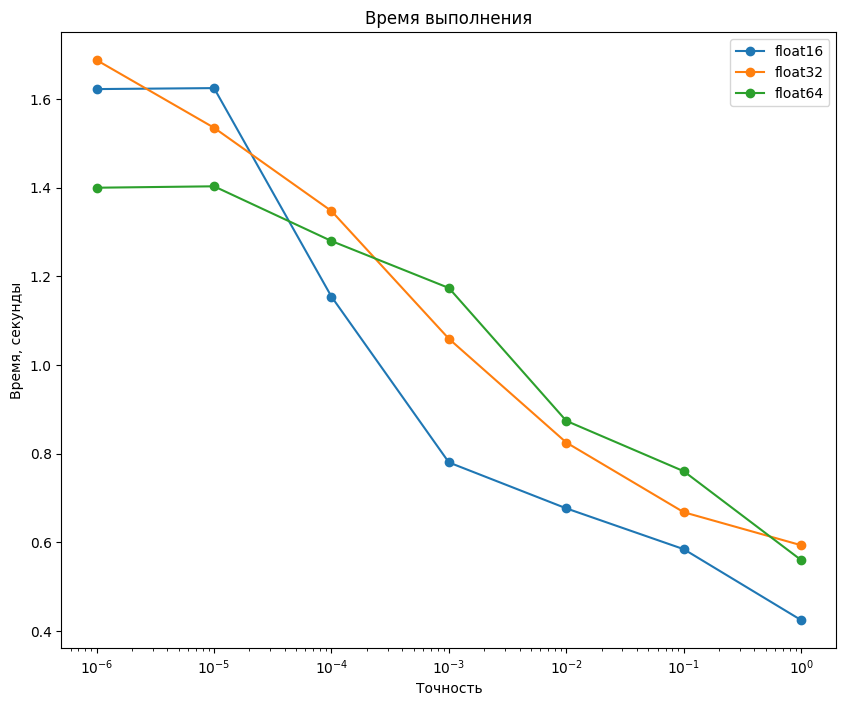

In [158]:
times = dict(zip(res.dtype.unique().tolist(),[[0]]*res.dtype.unique().tolist().__len__()))
for i in times.keys():
    times[i]= (res[res.dtype == i]['time'].values)
    
pd.DataFrame(times,index = tols).plot(style = '-o')
plt.xscale('log')
plt.title('Время выполнения')
plt.xlabel('Точность')
plt.ylabel('Время, секунды')
plt.show()

  0%|          | 0/7 [00:00<?, ?it/s]

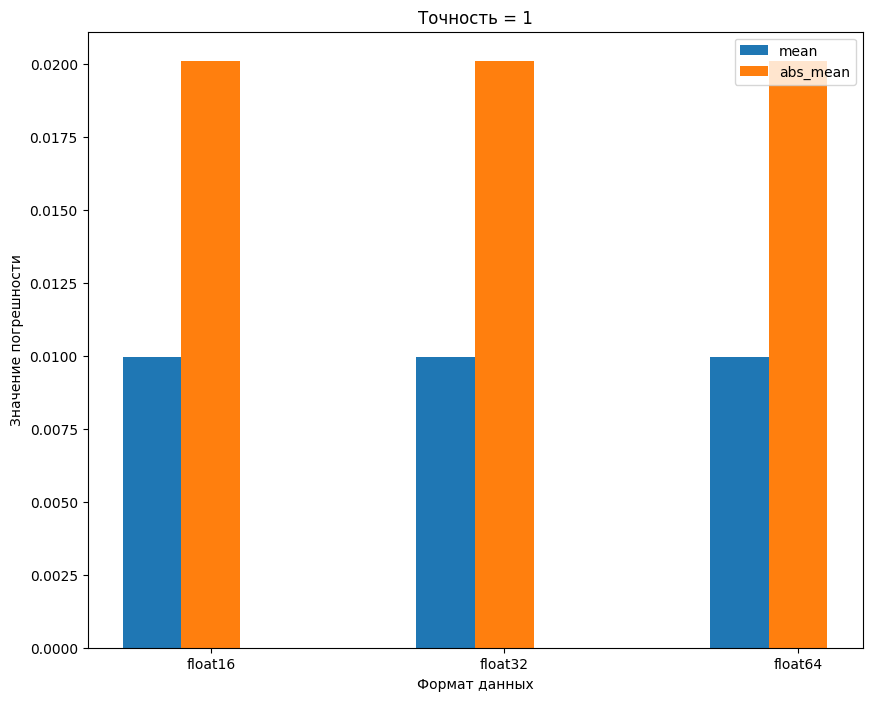

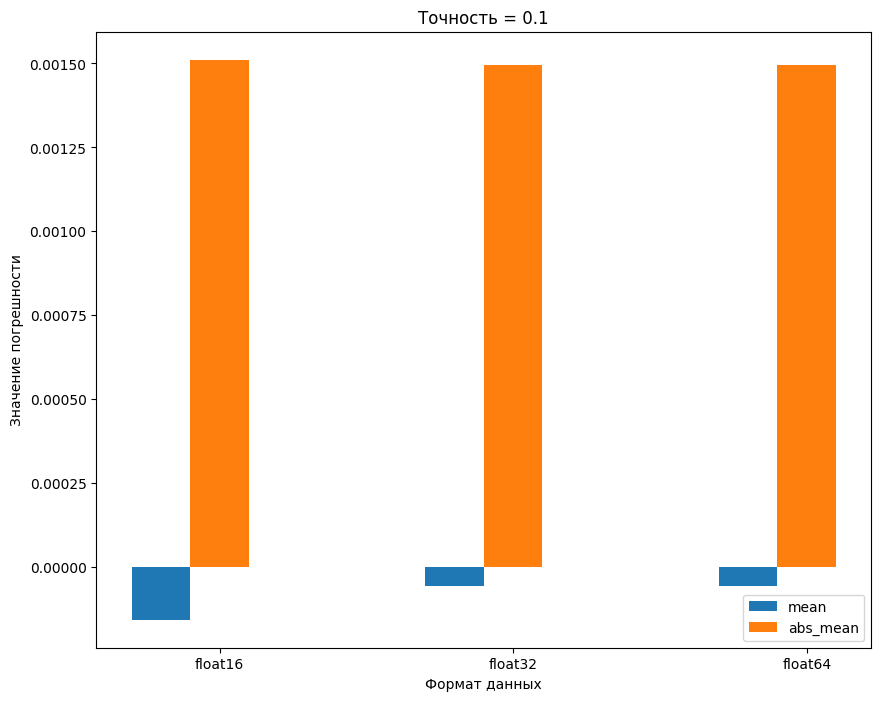

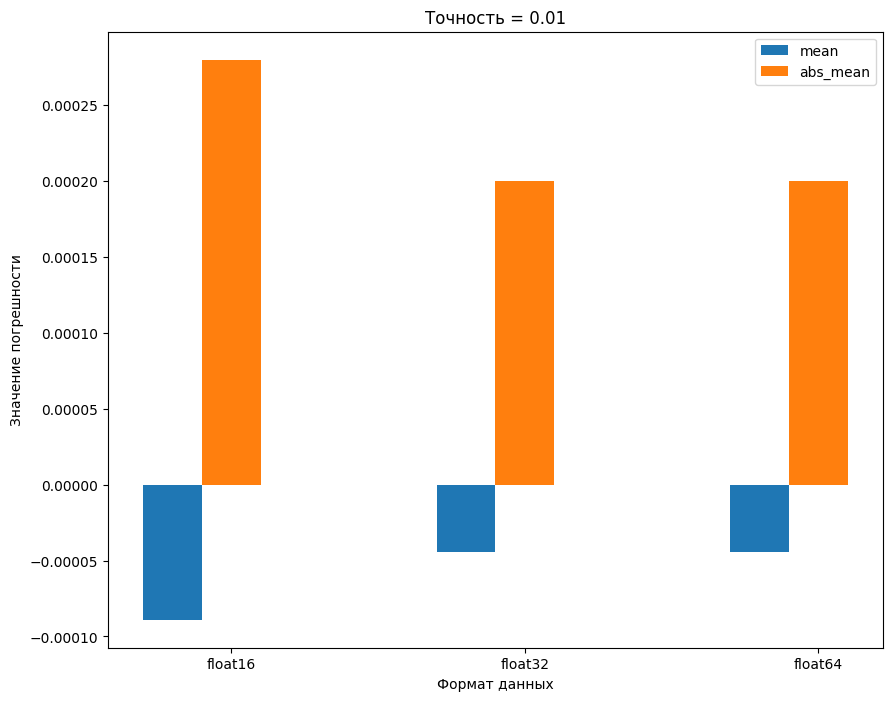

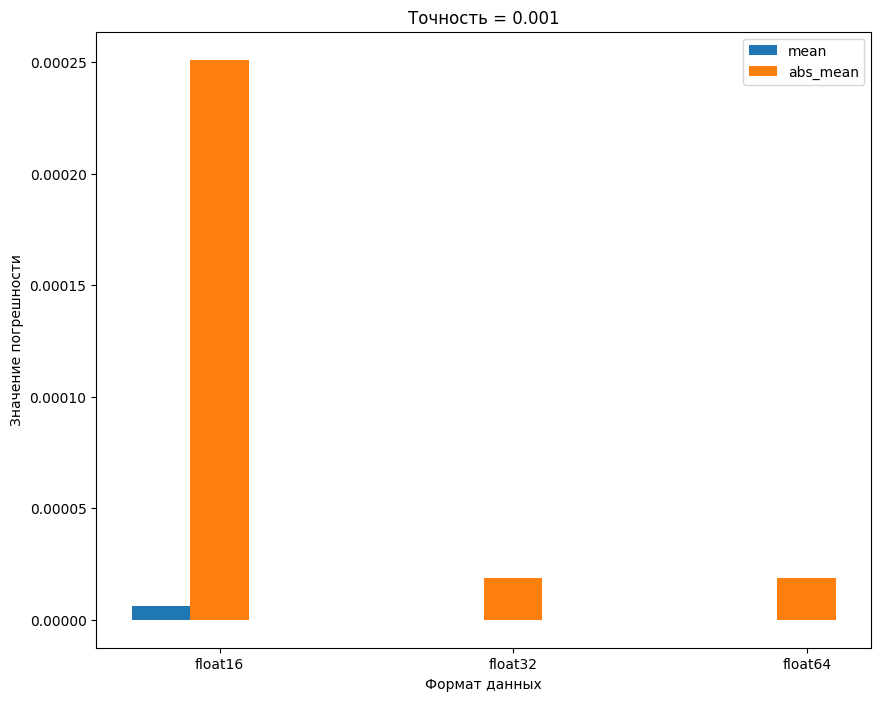

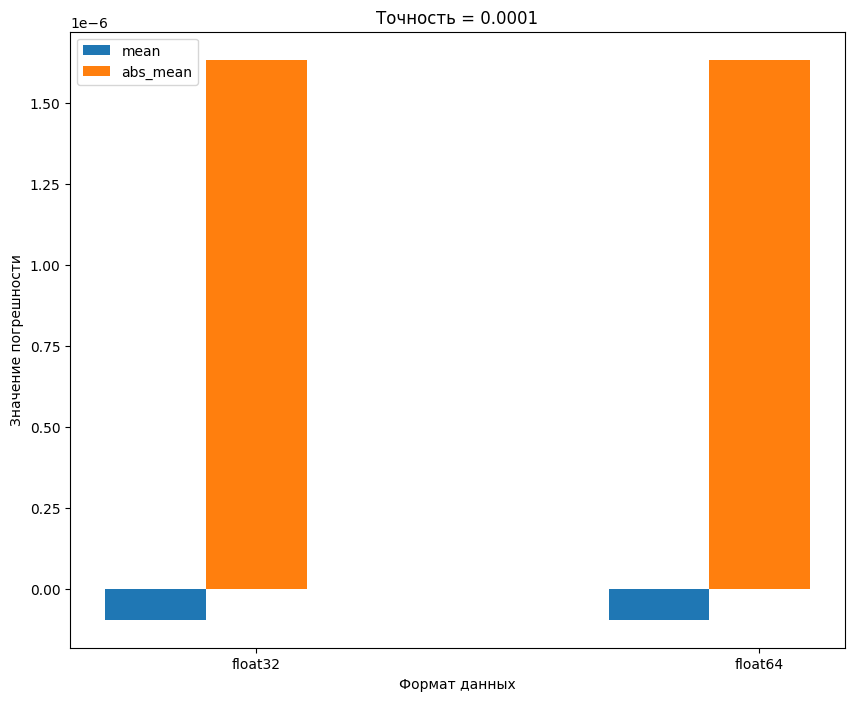

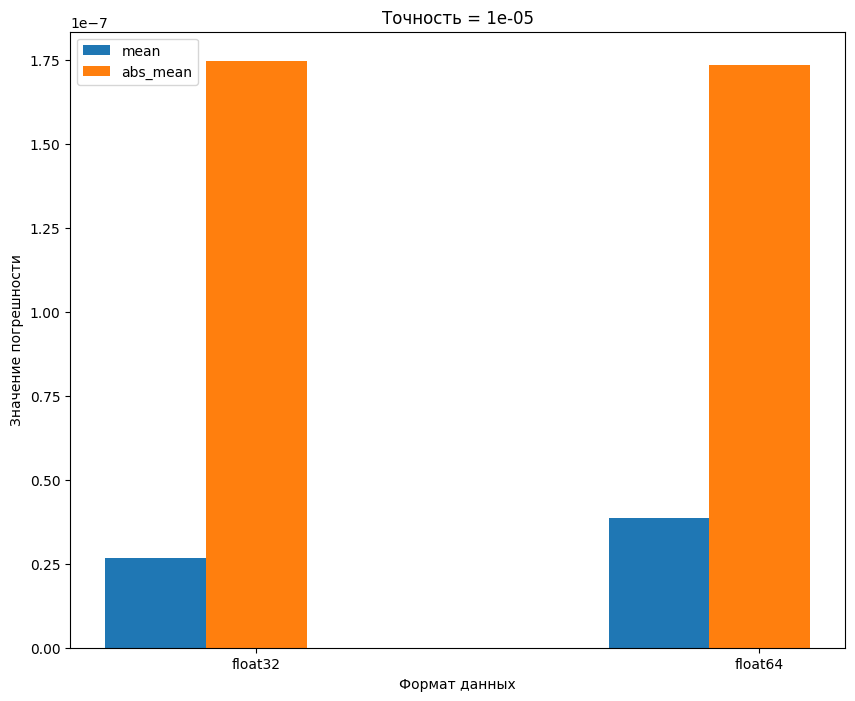

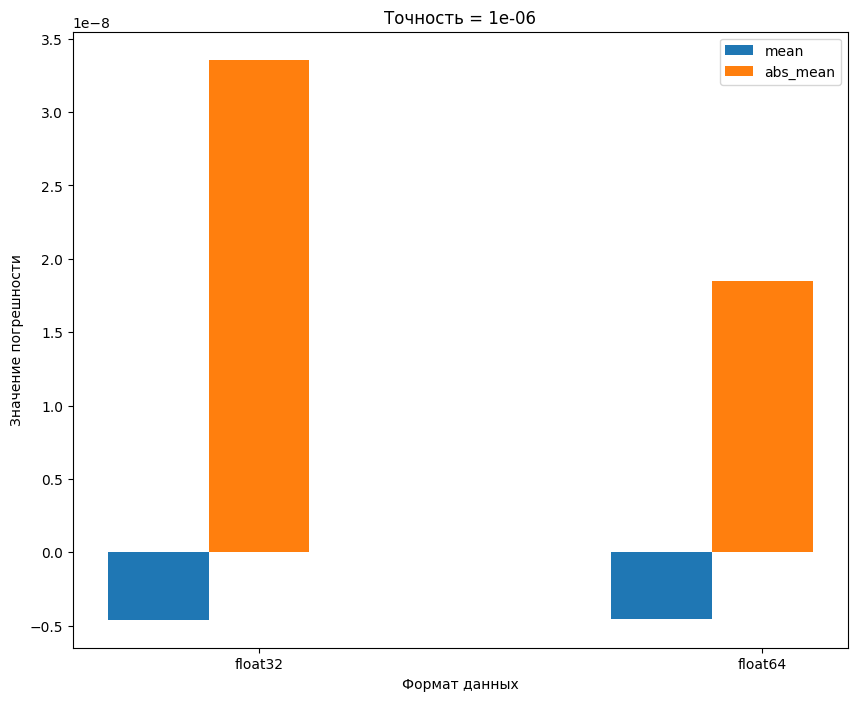

In [159]:
labels = ['mean', 'abs_mean']
width = 0.2
frm=0
x = np.arange(res.dtype.unique().__len__())
for bisection_tol in tqdm(tols):
    fig, ax = plt.subplots()
    if bisection_tol == 1e-4:
        x = np.arange(res.dtype.unique().__len__()-1)
        frm = 1
    for i in range(len(labels)):
        rects1 = ax.bar(x + width*i, res[res.tol == bisection_tol][labels[i]].values.tolist()[frm:], width, label=labels[i])
    
    ax.set_xticks(x+width)
    ax.set_xticklabels(res[res.tol == bisection_tol]['dtype'].values.tolist()[frm:])
    ax.set_title(f'Точность = {bisection_tol}')
    ax.legend()
    plt.ylabel('Значение погрешности')
    plt.xlabel('Формат данных')
    plt.show()

Ошибка всегда меньше у `float64`, и всегда больше у `float16`